CELL 1: IMPORTS & SETUP

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support

# Configuration
DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Smaller batch size for EfficientNet due to memory requirements
LEARNING_RATE = 0.0001
EPOCHS = 15
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")
if device.type == 'cuda':
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1e9:.1f} GB")
    torch.cuda.empty_cache()  # Clear GPU cache
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    # Set memory growth
    torch.backends.cudnn.benchmark = True

Using Device: cuda
GPU Memory: 8.0 GB
GPU Name: NVIDIA GeForce RTX 3070 Ti


CELL 2: DATASET CLASS

In [2]:
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

CELL 3: TRAINING ENGINE (WITH HISTORY TRACKING)

In [3]:
def train_and_evaluate_with_history(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    history = {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': []
    }
    
    print(f"\n--- Training {model_name} ---")
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        history['train_acc'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation Phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = val_loss / len(test_loader)
        history['val_acc'].append(epoch_val_acc)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.1f}% | Val Acc: {epoch_val_acc:.1f}%")
            
    return history

CELL 4: STAGE 1 - RAW DATA (BASELINE)

In [4]:
print("--- STAGE 1: EfficientNet-B0 Baseline (Raw Data) ---")

# 1. Basic Transform (Only Resize & Normalize)
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Setup Data
dataset_basic = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)
indices = list(range(len(dataset_basic)))
split = int(np.floor(0.2 * len(dataset_basic)))
np.random.seed(SEED)
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])

train_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Load EfficientNet-B0 (Pre-trained)
model_efficientnet_basic = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Freeze early layers to save memory and training time
for param in model_efficientnet_basic.features.parameters():
    param.requires_grad = False

# Modify the classifier for 2 classes (Healthy vs GON+)
num_features = model_efficientnet_basic.classifier[1].in_features
model_efficientnet_basic.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)
)

# 4. Train Baseline Model
history_basic = train_and_evaluate_with_history(
    model_efficientnet_basic, train_loader_basic, test_loader_basic, EPOCHS, "EfficientNet-B0 Baseline"
)

--- STAGE 1: EfficientNet-B0 Baseline (Raw Data) ---

--- Training EfficientNet-B0 Baseline ---
Epoch 1/15 | Train Acc: 69.7% | Val Acc: 79.9%
Epoch 2/15 | Train Acc: 74.1% | Val Acc: 83.2%
Epoch 3/15 | Train Acc: 76.8% | Val Acc: 86.6%
Epoch 4/15 | Train Acc: 80.3% | Val Acc: 91.3%
Epoch 5/15 | Train Acc: 83.6% | Val Acc: 92.6%
Epoch 6/15 | Train Acc: 86.1% | Val Acc: 92.6%
Epoch 7/15 | Train Acc: 88.0% | Val Acc: 93.3%
Epoch 8/15 | Train Acc: 88.5% | Val Acc: 95.3%
Epoch 9/15 | Train Acc: 89.1% | Val Acc: 95.3%
Epoch 10/15 | Train Acc: 91.0% | Val Acc: 95.3%
Epoch 11/15 | Train Acc: 91.1% | Val Acc: 95.3%
Epoch 12/15 | Train Acc: 91.0% | Val Acc: 95.3%
Epoch 13/15 | Train Acc: 92.8% | Val Acc: 95.3%
Epoch 14/15 | Train Acc: 91.8% | Val Acc: 95.3%
Epoch 15/15 | Train Acc: 92.3% | Val Acc: 96.6%


CELL 5: STAGE 2 - AUGMENTED DATA

In [5]:
print("\n--- STAGE 2: EfficientNet-B0 Augmented (Enhanced) ---")

# 1. Augmented Transform
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(IMG_SIZE[0], scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Setup Augmented Data
dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

# Use SAME split indices for fair comparison
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Load Fresh EfficientNet-B0
model_efficientnet_aug = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
for param in model_efficientnet_aug.features.parameters():
    param.requires_grad = False
num_features = model_efficientnet_aug.classifier[1].in_features
model_efficientnet_aug.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)
)

# 4. Train Augmented Model
history_aug = train_and_evaluate_with_history(
    model_efficientnet_aug, train_loader_aug, test_loader_aug, EPOCHS, "EfficientNet-B0 Augmented"
)


--- STAGE 2: EfficientNet-B0 Augmented (Enhanced) ---

--- Training EfficientNet-B0 Augmented ---
Epoch 1/15 | Train Acc: 66.1% | Val Acc: 73.8%
Epoch 2/15 | Train Acc: 73.4% | Val Acc: 77.2%
Epoch 3/15 | Train Acc: 73.9% | Val Acc: 79.2%
Epoch 4/15 | Train Acc: 76.4% | Val Acc: 83.2%
Epoch 5/15 | Train Acc: 76.9% | Val Acc: 79.9%
Epoch 6/15 | Train Acc: 78.8% | Val Acc: 84.6%
Epoch 7/15 | Train Acc: 81.1% | Val Acc: 87.9%
Epoch 8/15 | Train Acc: 80.8% | Val Acc: 87.9%
Epoch 9/15 | Train Acc: 83.3% | Val Acc: 90.6%
Epoch 10/15 | Train Acc: 85.1% | Val Acc: 89.9%
Epoch 11/15 | Train Acc: 83.9% | Val Acc: 87.2%
Epoch 12/15 | Train Acc: 85.1% | Val Acc: 88.6%
Epoch 13/15 | Train Acc: 85.3% | Val Acc: 90.6%
Epoch 14/15 | Train Acc: 86.0% | Val Acc: 90.6%
Epoch 15/15 | Train Acc: 84.9% | Val Acc: 90.6%


CELL 6: STAGE 3 - 5-FOLD CROSS-VALIDATION

In [6]:
print("\n--- STAGE 3: 5-Fold Cross-Validation ---")

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []
dataset_cv = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_cv)):
    print(f"Fold {fold+1}/5...")
    
    # Samplers for this fold
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    # Data loaders for this fold
    trainloader = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valloader = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=val_subsampler)
    
    # Initialize new model for each fold
    model_cv = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    for param in model_cv.features.parameters():
        param.requires_grad = False
    num_features = model_cv.classifier[1].in_features
    model_cv.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_features, 2)
    )
    model_cv = model_cv.to(device)  # Ensure model is on GPU
    
    optimizer = optim.Adam(model_cv.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # Train for fewer epochs in CV to save time
    for epoch in range(8):
        model_cv.train()
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_cv(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    # Validation for this fold
    model_cv.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in valloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cv(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    fold_acc = 100 * correct / total
    cv_scores.append(fold_acc)
    print(f"   Accuracy: {fold_acc:.2f}%")

avg_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print(f"\n5-Fold CV Results:")
print(f"Average Accuracy: {avg_cv_score:.2f}% ± {std_cv_score:.2f}%")
print(f"Individual Scores: {[f'{score:.1f}%' for score in cv_scores]}")


--- STAGE 3: 5-Fold Cross-Validation ---
Fold 1/5...
   Accuracy: 88.00%
Fold 2/5...
   Accuracy: 88.00%
Fold 3/5...
   Accuracy: 83.22%
Fold 4/5...
   Accuracy: 83.89%
Fold 5/5...
   Accuracy: 86.58%

5-Fold CV Results:
Average Accuracy: 85.94% ± 2.02%
Individual Scores: ['88.0%', '88.0%', '83.2%', '83.9%', '86.6%']


CELL 7: COMPREHENSIVE VISUALIZATION & METRICS


=== GENERATING COMPREHENSIVE EFFICIENTNET ANALYSIS ===


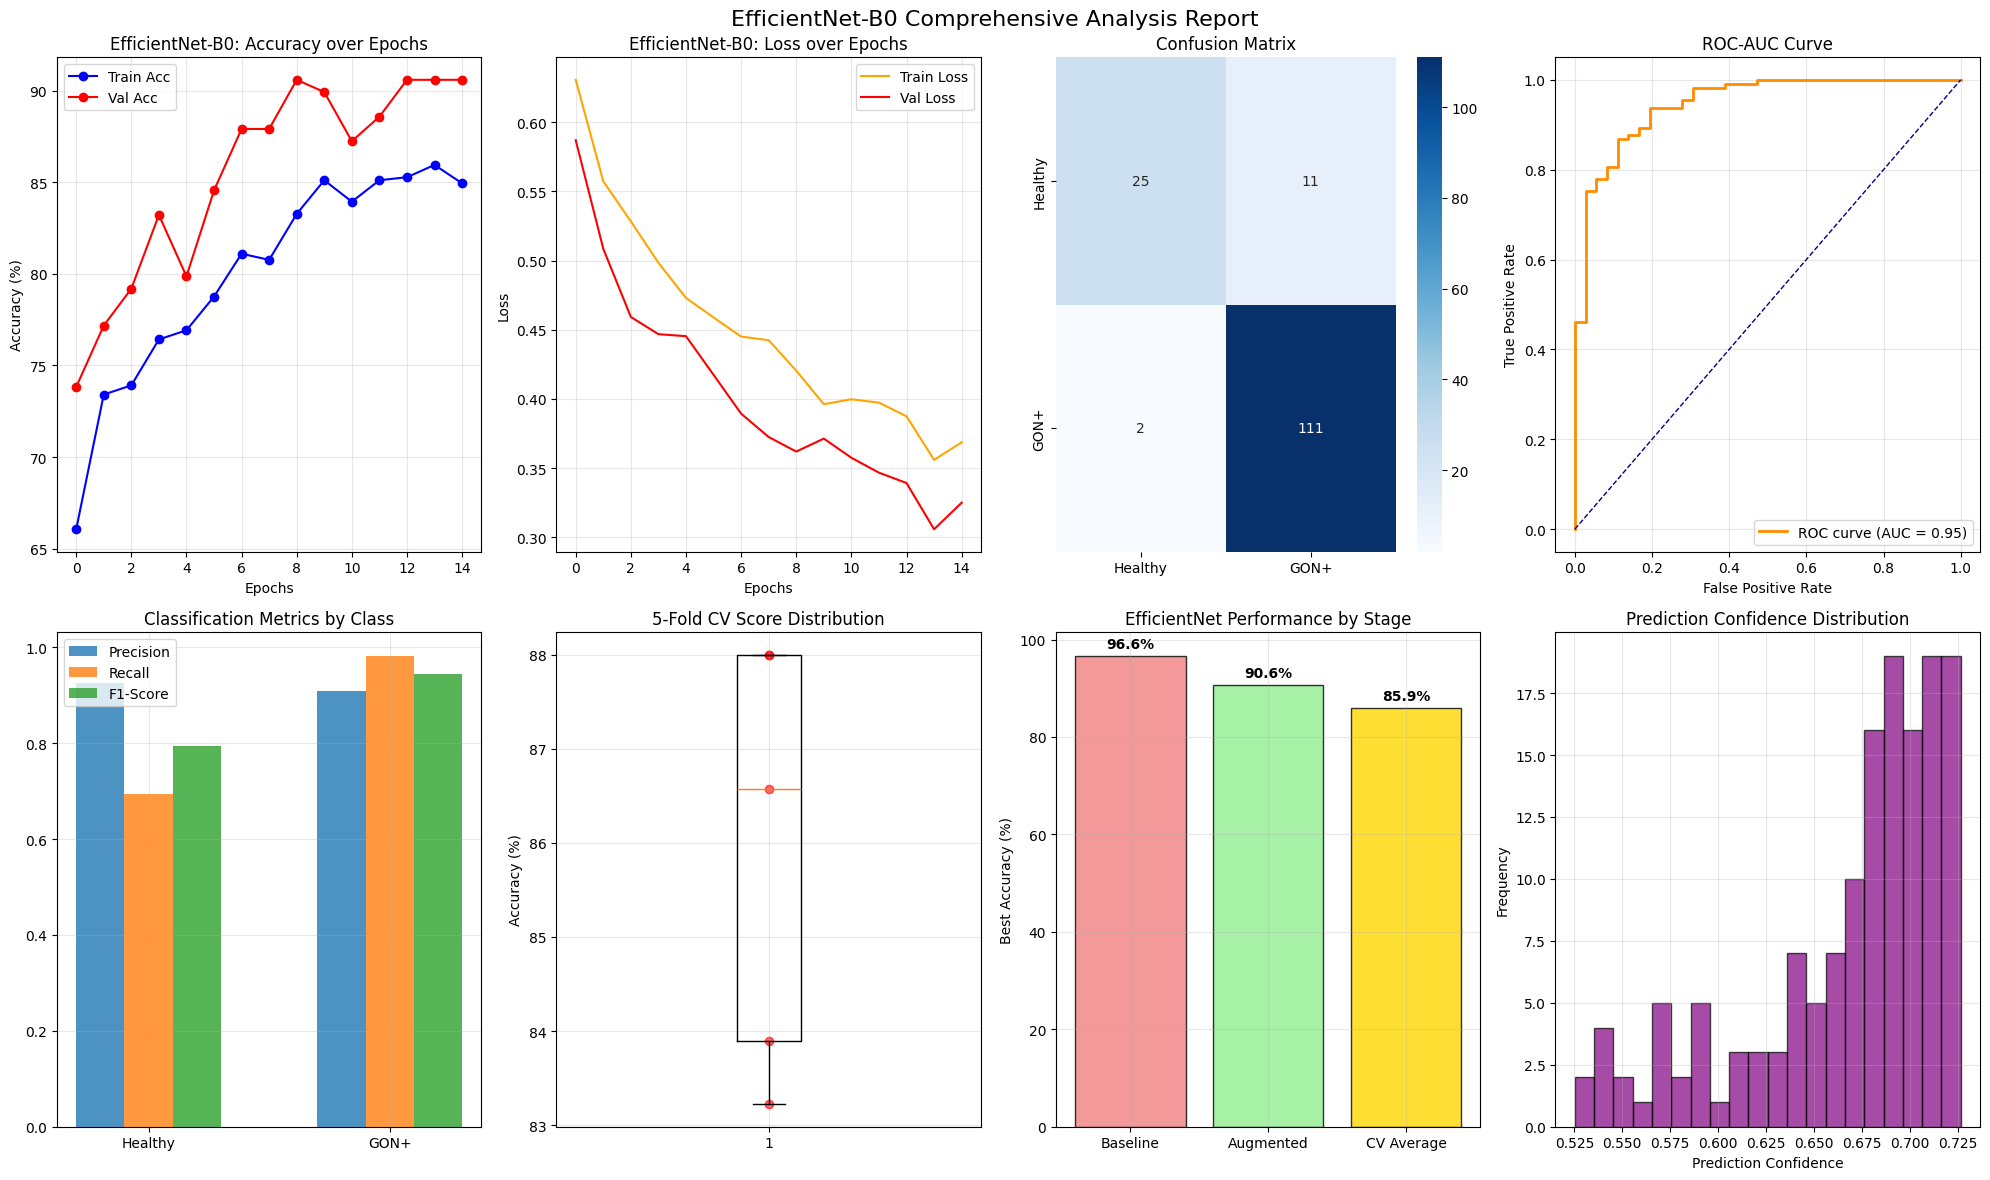

In [7]:
def show_comprehensive_report(history, model, loader, device):
    plt.figure(figsize=(20, 12))
    
    # 1. Training History - Accuracy
    plt.subplot(2, 4, 1)
    plt.plot(history['train_acc'], label='Train Acc', marker='o', color='blue')
    plt.plot(history['val_acc'], label='Val Acc', marker='o', color='red')
    plt.title('EfficientNet-B0: Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Training History - Loss
    plt.subplot(2, 4, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='orange')
    plt.plot(history['val_loss'], label='Val Loss', color='red')
    plt.title('EfficientNet-B0: Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Get predictions for further analysis
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())
    
    # 3. Confusion Matrix
    plt.subplot(2, 4, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Healthy', 'GON+'], yticklabels=['Healthy', 'GON+'])
    plt.title('Confusion Matrix')
    
    # 4. ROC Curve
    plt.subplot(2, 4, 4)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Precision, Recall, F1-Score
    plt.subplot(2, 4, 5)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    x = np.arange(2)
    width = 0.2
    plt.bar(x - width, precision, width, label='Precision', alpha=0.8)
    plt.bar(x, recall, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    plt.xticks(x, ['Healthy', 'GON+'])
    plt.title('Classification Metrics by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Cross-Validation Scores Distribution
    plt.subplot(2, 4, 6)
    plt.boxplot(cv_scores)
    plt.scatter([1] * len(cv_scores), cv_scores, alpha=0.6, color='red')
    plt.ylabel('Accuracy (%)')
    plt.title('5-Fold CV Score Distribution')
    plt.grid(True, alpha=0.3)
    
    # 7. Model Comparison (Stages)
    plt.subplot(2, 4, 7)
    stages = ['Baseline', 'Augmented', 'CV Average']
    scores = [max(history_basic['val_acc']), max(history_aug['val_acc']), avg_cv_score]
    colors = ['lightcoral', 'lightgreen', 'gold']
    bars = plt.bar(stages, scores, color=colors, edgecolor='black', alpha=0.8)
    plt.ylabel('Best Accuracy (%)')
    plt.title('EfficientNet Performance by Stage')
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{score:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 8. Prediction Confidence Distribution
    plt.subplot(2, 4, 8)
    confidences = [max(torch.nn.functional.softmax(torch.tensor([0, conf]), dim=0).numpy()) for conf in y_probs]
    plt.hist(confidences, bins=20, alpha=0.7, color='purple', edgecolor='black')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('EfficientNet-B0 Comprehensive Analysis Report', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Generate comprehensive report
print("\n=== GENERATING COMPREHENSIVE EFFICIENTNET ANALYSIS ===")
show_comprehensive_report(history_aug, model_efficientnet_aug, test_loader_aug, device)

CELL 8: PREDICTION VISUALIZATION


--- EfficientNet-B0 Prediction Visualization ---


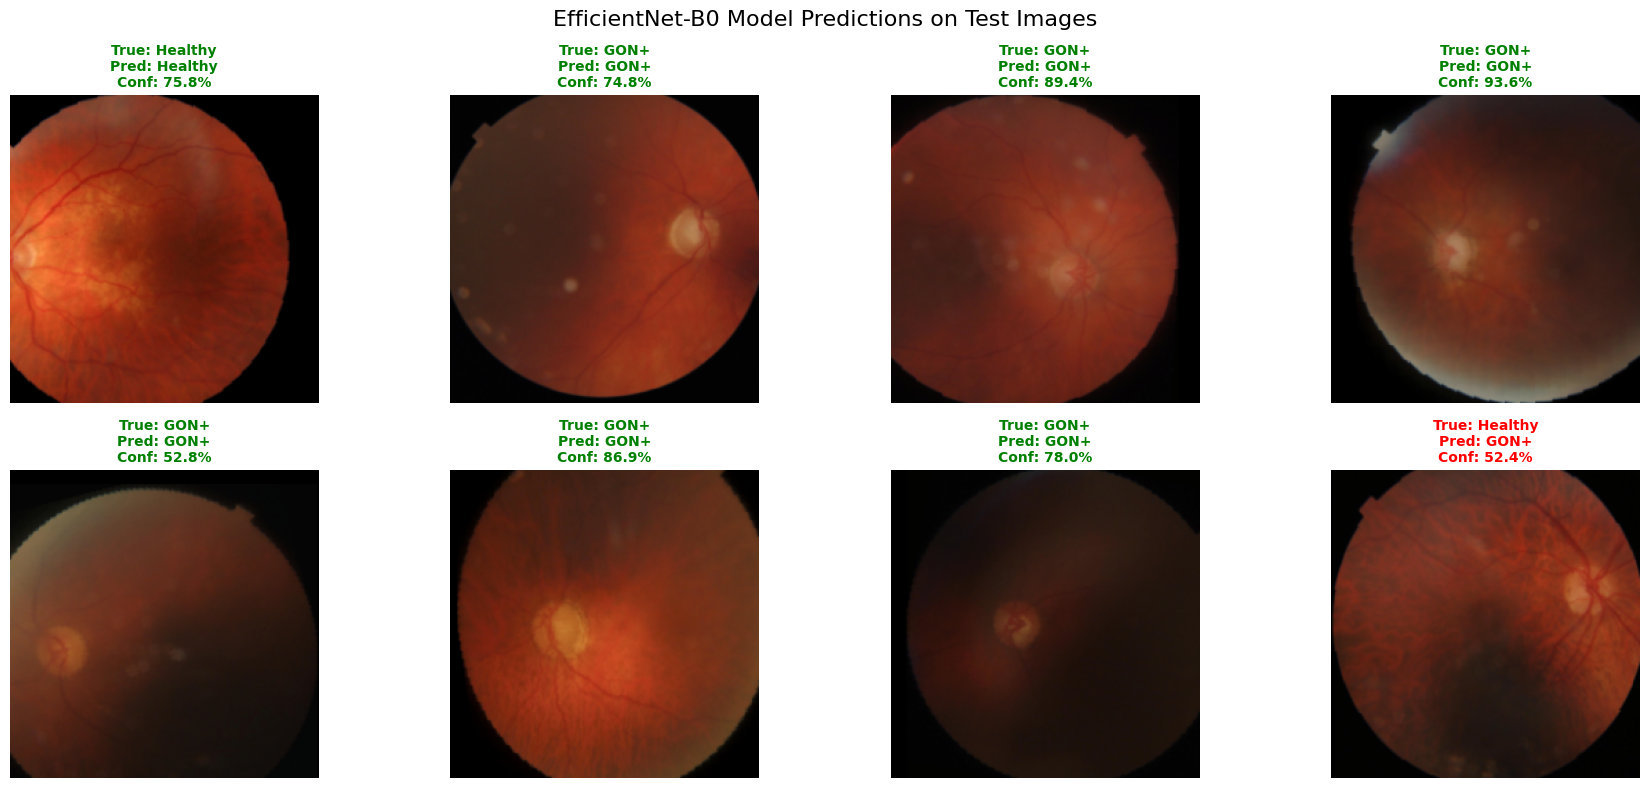

In [8]:
def visualize_efficientnet_predictions(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probs, 1)
    
    # Visualization
    plt.figure(figsize=(18, 8))
    class_names = ['Healthy', 'GON+']
    
    # Show more samples
    num_samples = min(8, len(images))
    
    for i in range(num_samples):
        ax = plt.subplot(2, 4, i+1)
        
        # Denormalize image for display
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_label = class_names[labels[i].item()]
        pred_label = class_names[predictions[i].item()]
        confidence = confidences[i].item() * 100
        
        # Color coding: Green for correct, Red for incorrect
        color = 'green' if true_label == pred_label else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%", 
                  color=color, fontweight='bold', fontsize=10)
        plt.axis('off')
        
    plt.suptitle("EfficientNet-B0 Model Predictions on Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\n--- EfficientNet-B0 Prediction Visualization ---")
visualize_efficientnet_predictions(model_efficientnet_aug, test_loader_aug, device)

CELL 9: FINAL SUMMARY & MODEL SAVING

In [9]:
# Final Summary
print("\n" + "="*50)
print("       EFFICIENTNET-B0 FINAL RESULTS SUMMARY       ")
print("="*50)
print(f"Stage 1 - Baseline (Raw):     {max(history_basic['val_acc']):.2f}%")
print(f"Stage 2 - Augmented:          {max(history_aug['val_acc']):.2f}%")
print(f"Stage 3 - 5-Fold CV:         {avg_cv_score:.2f}% ± {std_cv_score:.2f}%")
print("="*50)
print(f"Best Model: {'Augmented' if max(history_aug['val_acc']) > max(history_basic['val_acc']) else 'Baseline'}")
print(f"Improvement: +{max(history_aug['val_acc']) - max(history_basic['val_acc']):.2f}% (Augmentation vs Baseline)")
print("="*50)

# Save the best model (augmented version)
save_path = os.path.join(DATASET_ROOT, 'efficientnet_b0_best_model.pth')
torch.save(model_efficientnet_aug.state_dict(), save_path)
print(f"\n✅ EfficientNet-B0 Best Model Saved: {save_path}")

# Additional model information
print(f"\n📊 Model Information:")
print(f"   Architecture: EfficientNet-B0 (Pre-trained)")
print(f"   Input Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Training Epochs: {EPOCHS}")
print(f"   Device Used: {device}")

# Classification Report for the best model
print(f"\n📈 Detailed Classification Report (Best Model):")
model_efficientnet_aug.eval()
y_true_final, y_pred_final = [], []
with torch.no_grad():
    for images, labels in test_loader_aug:
        images, labels = images.to(device), labels.to(device)
        outputs = model_efficientnet_aug(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true_final.extend(labels.cpu().numpy())
        y_pred_final.extend(predicted.cpu().numpy())

print(classification_report(y_true_final, y_pred_final, 
                          target_names=['Healthy', 'GON+'], digits=4))

print("\n🎯 EfficientNet-B0 model training and evaluation completed successfully!")


       EFFICIENTNET-B0 FINAL RESULTS SUMMARY       
Stage 1 - Baseline (Raw):     96.64%
Stage 2 - Augmented:          90.60%
Stage 3 - 5-Fold CV:         85.94% ± 2.02%
Best Model: Baseline
Improvement: +-6.04% (Augmentation vs Baseline)

✅ EfficientNet-B0 Best Model Saved: C:\Projects\Thesis-Fall-25-26--G-606-main\efficientnet_b0_best_model.pth

📊 Model Information:
   Architecture: EfficientNet-B0 (Pre-trained)
   Input Size: (224, 224)
   Batch Size: 16
   Learning Rate: 0.0001
   Training Epochs: 15
   Device Used: cuda

📈 Detailed Classification Report (Best Model):
              precision    recall  f1-score   support

     Healthy     0.9615    0.6944    0.8065        36
        GON+     0.9106    0.9912    0.9492       113

    accuracy                         0.9195       149
   macro avg     0.9361    0.8428    0.8778       149
weighted avg     0.9229    0.9195    0.9147       149


🎯 EfficientNet-B0 model training and evaluation completed successfully!
